In [10]:
%matplotlib inline

## Functions:

In [11]:
import pandas as pd

def readTimeSeriesFromCSV(pathFileCSV, indexColumn):
    
    df = pd.read_csv(pathFileCSV, index_col = indexColumn)
    df.index.name = None
    df.reset_index(inplace = True)
    return df

In [12]:
def plotRollingMeanSTD(timeSeries, windowRange):
    
    # Determing rolling statistics
    rollingMean = timeSeries.rolling(window = windowRange, center = False).mean()
    rollingSTD = timeSeries.rolling(window = windowRange, center = False).std()

    # Plot rolling statistics:
    fig = plt.figure(figsize = (15, 8))
    orig = plt.plot(timeSeries, color = 'blue', label = 'Original')
    mean = plt.plot(rollingMean, color = 'red', label = 'Rolling Mean')
    std = plt.plot(rollingSTD, color = 'black', label = 'Rolling STD')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & STD')
    return

In [13]:
from statsmodels.tsa.stattools import adfuller

def DickeyFullerTest(timeSeries):
    
    # Perform Dickey-Fuller Test:
    DFAIC = adfuller(timeSeries, autolag = 'AIC')
    DFAIC_OUT = pd.Series(DFAIC[0:4], index = ['Test Statistic:','p-value:','Lag No.:','Observation No.:'])
    for key, value in DFAIC[4].items():
        DFAIC_OUT['Critical Value (%s)'%key] = value

    print 'Results of Dickey-Fuller Test:'
    print DFAIC_OUT
    return

In [14]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

def decomposSeasonality(timeSeries, modelType = "additive"):

    # model : str{"additive", "multiplicative"}
    # The additive model:       Y[t] = T[t] + S[t] + e[t]
    # The multiplicative model: Y[t] = T[t] * S[t] * e[t]
    
    decomposition = seasonal_decompose(timeSeries, model = modelType) 
    fig = plt.figure()
    fig = decomposition.plot()  
    fig.set_size_inches(15, 8)
    return decomposition

In [15]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf

def plotACFandPACF(timeSeries):
    fig = plt.figure(figsize=(15, 8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(timeSeries, ax = ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(timeSeries, ax = ax2)
    return

In [16]:
from statsmodels.tsa.arima_model import ARIMA

pdq=[]
aic=[]

def ARIMAcalculator(ts, p, d, q):
    for pi in range(1, p+1):
        for di in range(d):
            for qi in range(1, q+1):
                model = ARIMA(ts, (pi, di, qi)).fit(disp = -1)
                aic_i = model.aic
                pdq_i = pi, di, qi
                print (pdq_i, aic_i)

                aic.append(aic_i)
                pdq.append(pdq_i)

    keys = pdq
    values = aic
    d = dict(zip(keys, values))
    print (d)

    minaic = min(d, key = d.get)

    for i in range(3):
        p = minaic[0]
        d = minaic[1]
        q = minaic[2]
        
    print (p, d, q)
    return

## Loading the Time Series Data:

In [26]:
import datetime
from dateutil.relativedelta import relativedelta

df = pd.read_csv('ShampooSales.csv', header = 0, index_col = 0, squeeze = True)

start = datetime.datetime.strptime("2000-01-01", "%Y-%m-%d")
date_list = [start + relativedelta(months = x) for x in range(0, 36)]

ts = pd.Series(df.values, index = pd.DatetimeIndex(date_list))
ts.name = "Sales"

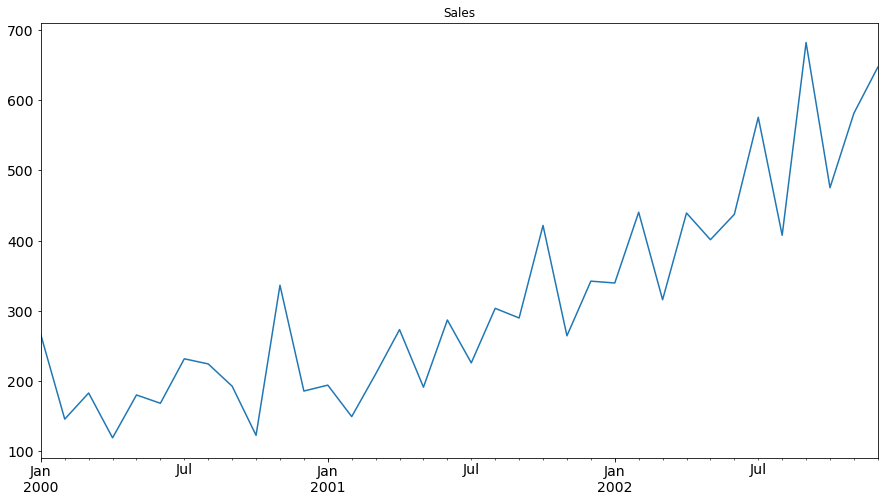

In [27]:
ts.plot(figsize = (15, 8), title = 'Sales', fontsize = 14)

## Seasonality Check:

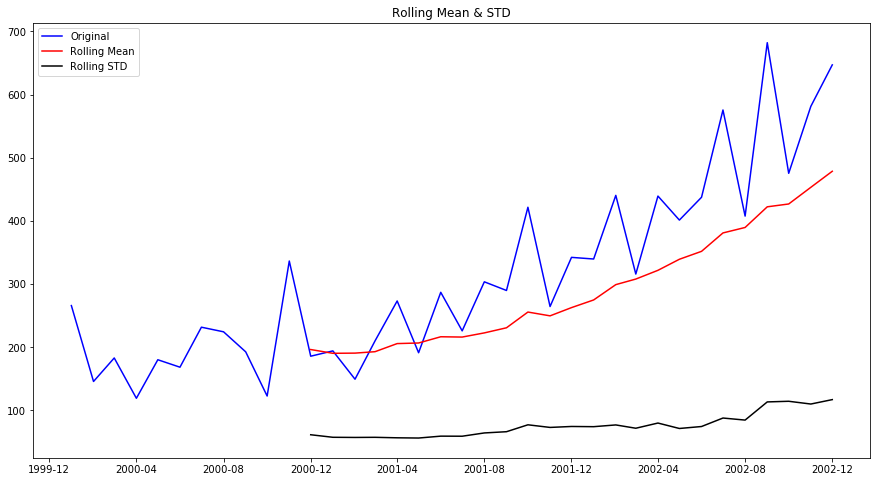

In [28]:
plotRollingMeanSTD(ts, 12)

In [29]:
DickeyFullerTest(ts)

Results of Dickey-Fuller Test:
Test Statistic:          3.060142
p-value:                 1.000000
Lag No.:                10.000000
Observation No.:        25.000000
Critical Value (5%)     -2.986489
Critical Value (1%)     -3.723863
Critical Value (10%)    -2.632800
dtype: float64


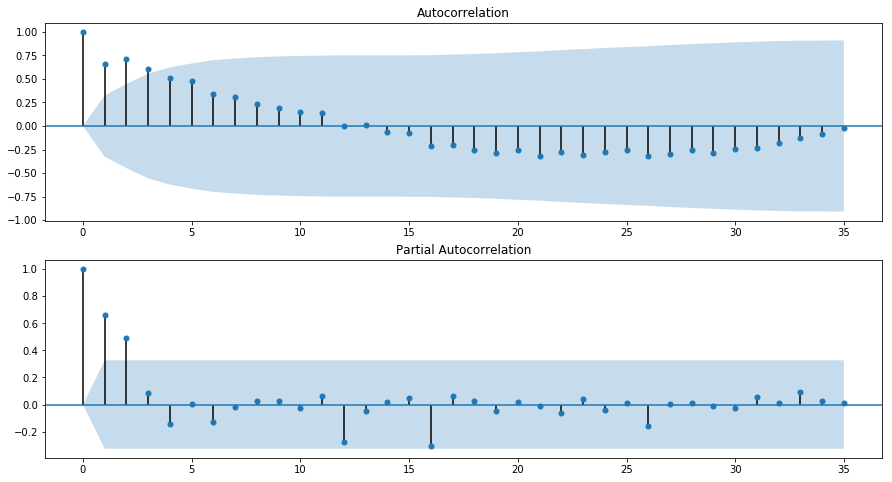

In [30]:
plotACFandPACF(ts)

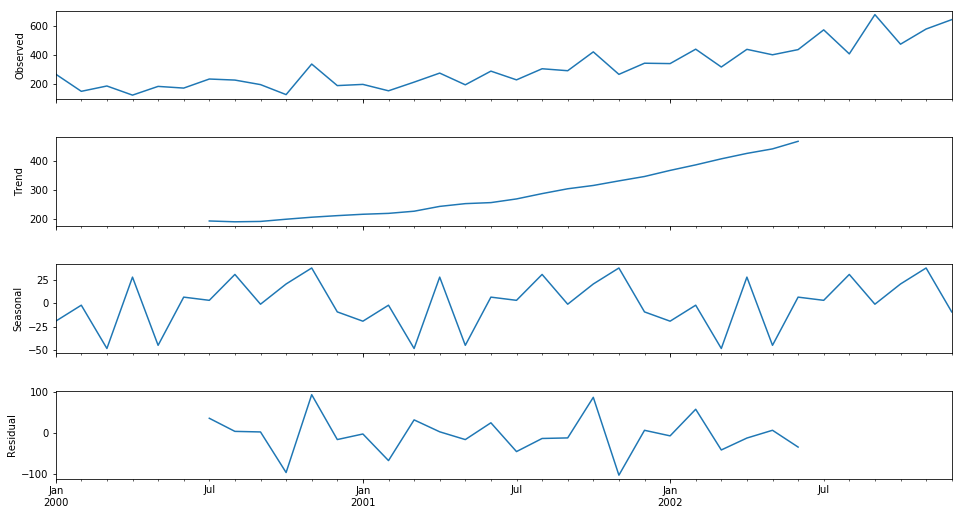

In [32]:
d1 = decomposSeasonality(ts)

In [33]:
d1_resid = d1.resid.dropna(inplace = False)
d1_trend = d1.trend.dropna(inplace = False)

In [35]:
#d2 = decomposSeasonality(ts, "multiplicative")

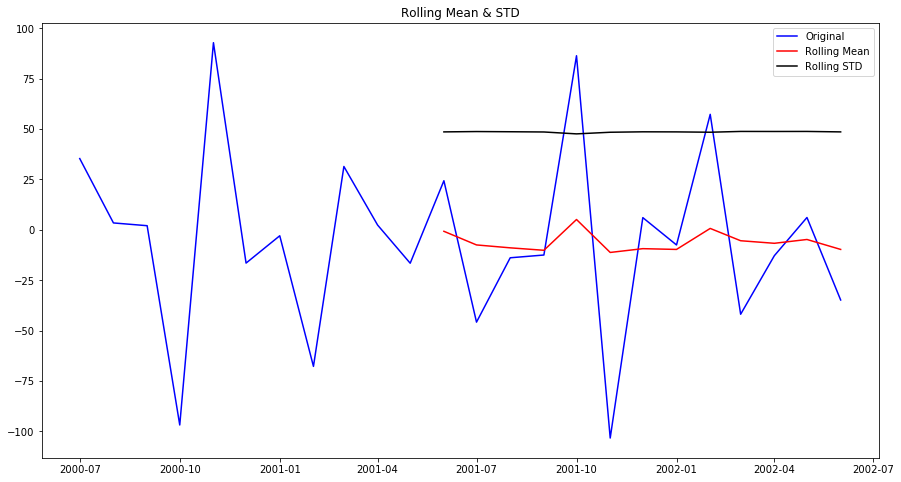

In [36]:
plotRollingMeanSTD(d1_resid, 12)

In [40]:
#plotRollingMeanSTD(d2.resid, 12)

In [37]:
DickeyFullerTest(d1_resid)

Results of Dickey-Fuller Test:
Test Statistic:         -0.991914
p-value:                 0.756202
Lag No.:                 6.000000
Observation No.:        17.000000
Critical Value (5%)     -3.054358
Critical Value (1%)     -3.889266
Critical Value (10%)    -2.666984
dtype: float64


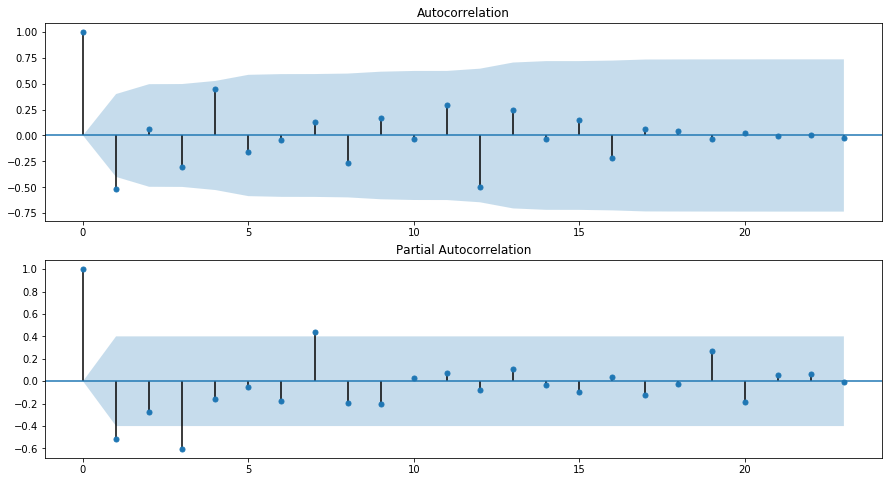

In [38]:
plotACFandPACF(d1_resid)

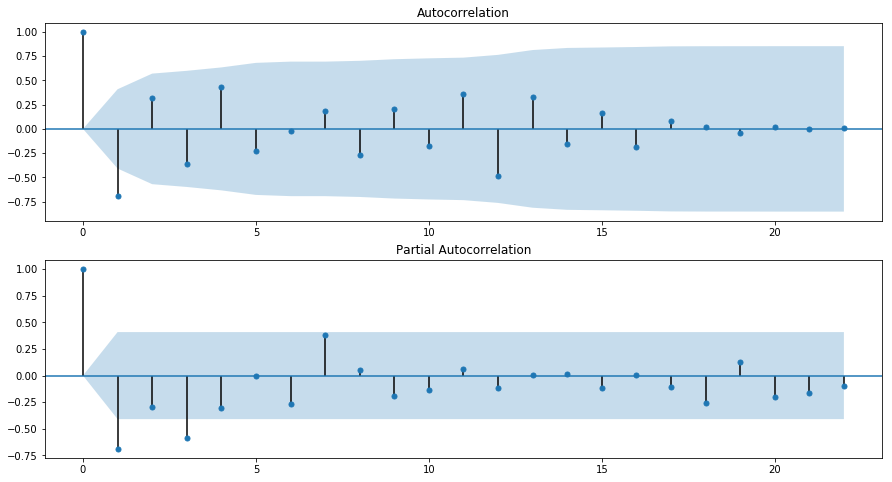

In [39]:
d1_resid_diff = (d1_resid - d1_resid.shift()).dropna(inplace = False)
plotACFandPACF(d1_resid_diff)

Differeing with shift function does not help that means ARIMA(p, 0, q) and ARIMA(p, 1, q) are the same

In [41]:
from statsmodels.tsa.arima_model import ARIMA

model_d1 = ARIMA(d1_resid, order = (3, 0, 3))
result_d1 = model_d1.fit()
print result_d1.summary()

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                   24
Model:                     ARMA(3, 3)   Log Likelihood                -108.563
Method:                       css-mle   S.D. of innovations             18.231
Date:                Tue, 21 Mar 2017   AIC                            233.125
Time:                        07:05:10   BIC                            242.550
Sample:                    07-01-2000   HQIC                           235.625
                         - 06-01-2002                                         
                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
const          -5.9555      0.421    -14.151      0.000        -6.780    -5.131
ar.L1.Sales    -1.1508      0.147     -7.809      0.000        -1.440    -0.862
ar.L2.Sales    -1.1128      0.156     -7.122    

In [281]:
#from statsmodels.tsa.arima_model import ARIMA

#model_d2 = ARIMA(d2.resid.dropna(inplace = False), order = (5,1,5))
#result_d2 = model_d2.fit(disp = -1)
#print result_d2.summary()

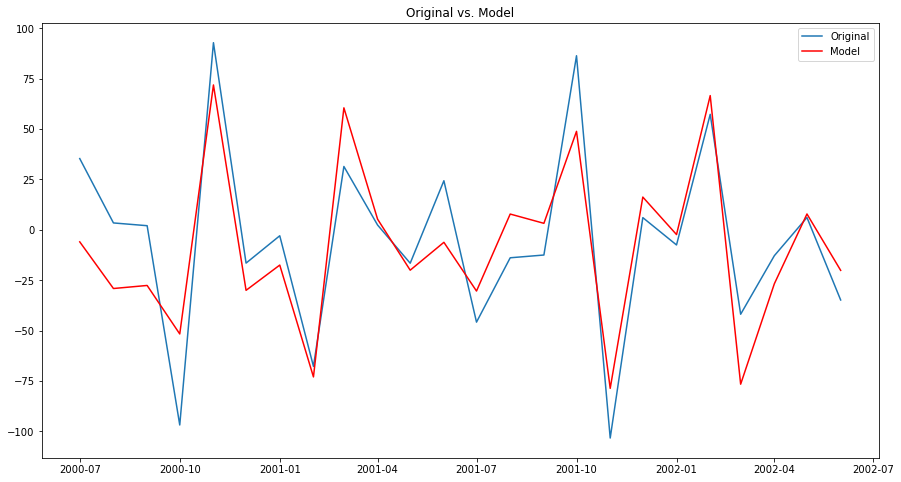

In [42]:
fig = plt.figure(figsize = (15, 8))
plt.plot(d1.resid.dropna(inplace = False), label = 'Original')
plt.plot(result_d1.fittedvalues, color = 'red', label = 'Model')
plt.legend(loc = 'best')
plt.title('Original vs. Model')

## Procedure to find Trend Prediction:

In [43]:
print d1_trend.index[0]
print d1_trend.index[len(d1_trend)-1]

2000-07-01 00:00:00
2002-06-01 00:00:00


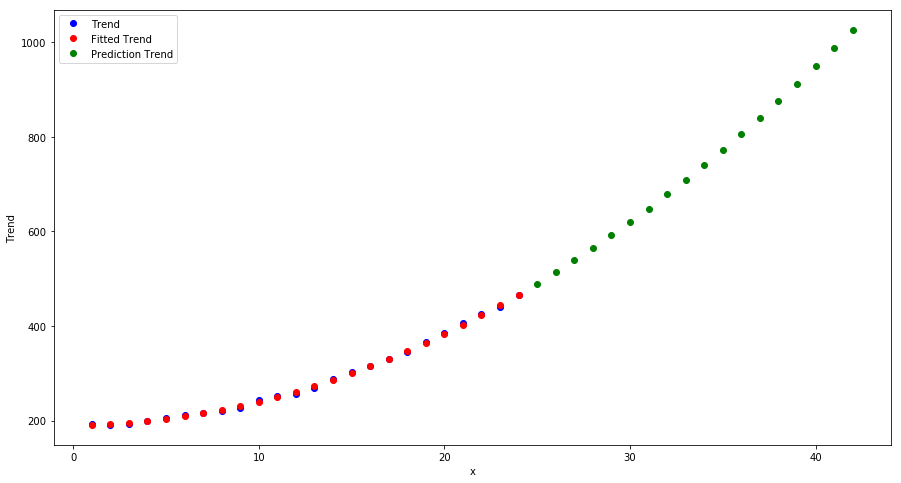

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

#def func(x, a, b, c, d, e, f):
#    ff = a*x**5 + b*x**4 + c*x**3 + d*x**2 + e*x**1 + f
#    return ff

def func(x, a, b, c):
    return a*x**2 + b*x**1 + c

y = d1_trend.values
x = np.linspace(1, len(y), len(y))

n_p = 18
len_ys = len(y) + n_p

xs = np.linspace(1, len_ys, len_ys)

popt, pcov = curve_fit(func, x, y)

xp = np.linspace(len(y) + 1, len_ys, n_p)

fig = plt.figure(figsize = (15, 8))
plt.plot(x, y, 'bo', label = 'Trend')
plt.plot(x, func(x, *popt), 'ro', label = 'Fitted Trend')
yp = func(xp, *popt)
plt.plot(xp, yp, 'go', label = 'Prediction Trend')

plt.xlabel('x')
plt.ylabel('Trend')
plt.legend(loc = 'best')
plt.show()

In [71]:
import datetime
from dateutil.relativedelta import relativedelta

start = datetime.datetime.strptime("2000-07-01", "%Y-%m-%d")
date_list = [start + relativedelta(months = x) for x in range(0, len(ts)+6)]
d1_trend_predict = pd.Series(np.array(y.tolist() + yp.tolist()), index = pd.DatetimeIndex(date_list))
d1_trend_predict.name = ts.name
print d1_trend_predict.index[0]
print d1_trend_predict.index[41]

2000-07-01 00:00:00
2003-12-01 00:00:00


## Calculating the Residual Prediction:

In [90]:
result_d1.forecast()

(array([ 3.41365063]),
 array([ 18.23053573]),
 array([[-32.31754283,  39.14484408]]))

In [75]:
d1_resid_predict = result_d1.predict(start = '2000-07-01', end = '2003-12-01')
d1_resid_predict.name = ts.name
#print d1_resid_predict

## Calculating the Seasonal Prediction:

In [83]:
import datetime
from dateutil.relativedelta import relativedelta

start = datetime.datetime.strptime("2003-01-01", "%Y-%m-%d")
date_tmp = [start + relativedelta(months = x) for x in range(0, 12)]
values_tmp = list(d1.seasonal.values[(len(ts)-12):len(ts)])

d1_seasonal_tmp = pd.Series(np.array(values_tmp), index = pd.DatetimeIndex(date_tmp))
d1_seasonal_tmp.name = ts.name
d1_seasonal = d1.seasonal
d1_seasonal_predict = d1_seasonal.append(d1_seasonal_tmp)
#d1_seasonal_predict

## Plot the Time Series Forecast:

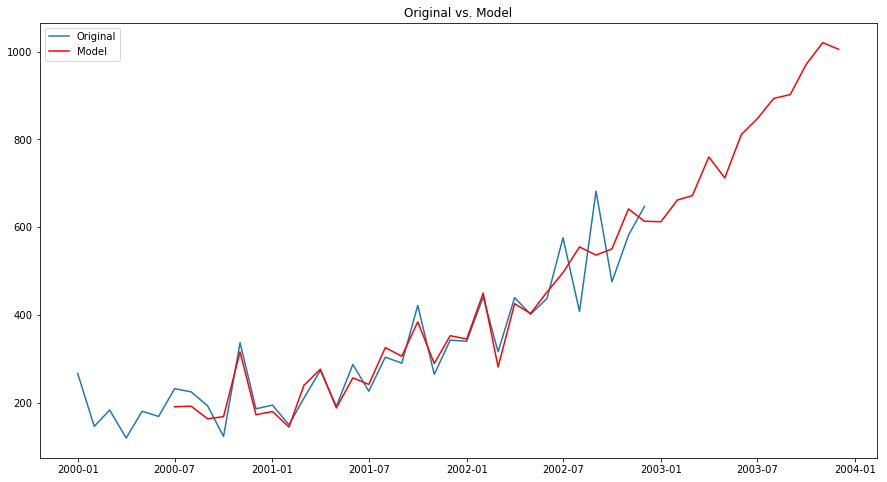

In [84]:
fig = plt.figure(figsize = (15, 8))
plt.plot(ts, label = 'Original')
d1_predict = d1_trend_predict + d1_seasonal_predict + d1_resid_predict
plt.plot(d1_predict, color = 'red', label = 'Model')
plt.legend(loc = 'best')
plt.title('Original vs. Model')
plt.show()